# T2 SME0104 - Cálculo Numérico
## Decodificador de sinais DTMF

Alunos: 
- Kauê Hunnicutt Bazilli - 11212226
- Matheus Vieira Gonçalves - 11200397
- Pedro Henrique dias Junqueira de Souza - 11294312

# Explicação
O projeto desenvolvido foi um decodificador de sinais DTMF (Dual-tone Multi-Frequency). 

Os sinais DTMF são os sons tons que tocam ao digitarmos números telefônicos. Cada número é representado por dois tons, sendo um de baixa e um de alta frequência. O conjunto desses dois tons é decodificado ao chegar na central telefônica, possibilitando converter o áudio desses sons no conjunto de caracteres digitados. 

Outro jeito de entender, para quem gosta de música, é interpretando cada um dos sinais DTMF é como uma harmonia composta por duas notas tocadas ao mesmo tempo. Cada uma dessas harmonias representa um dígito teclado em um telefone/celular.

O objetivo do projeto desenvolvido é criar um decodificador capaz de interpretar o som recebido utilizando o métodos dos mínimos quadrados, possibilitando obter os caracteres pressionados a partir dos sons DTMF.

Como o áudio é um sinal periódico, ele pode ser representado por uma série de Fourier, que é uma soma de senos e cossenos. Nosso objetivo é dado um som, achar uma aproximação da série de Fourier através do método dos mínimos quadrados e, a partir dessa aproximação, determinar quais os tons sendo tocados e inferir o valor digitado.

Essencialmente, precisamos:
1) Gravar o sinal de áudio
2) Isolar os sons tocados (ignorar o ruído de fundo do áudio)
3) Para cada um dos sons, achar uma soma de senoides que descreve esse som
4) Usar as somas de senoides encontradas para determinar as frequências tocadas
5) Sabendo as frequências, sabemos qual o dígito tocado

In [2]:
# Bibliotecas utilizadas 

import numpy as np
from scipy.ndimage import zoom
import sounddevice as sd
import matplotlib.pyplot as pp
import math

### Aqui, definimos diversas constantes que serão utilizadas ao longo do código.

In [4]:

SAMPLE_RATE = 22000  # Número de amostras da gravação
REC_TIME = 10.0  # Duração da gravação em segundos
FRAMES = int(REC_TIME * SAMPLE_RATE)  # Quantidade de frames da gravação
CHANNELS = 1  # Quantidade de canais. Apenas 1 é utilizado (áudio em mono)

# menor quantidade de tempo significativo durante a gravação
DELTA_T = 1.0 / SAMPLE_RATE

# Frequências DTMF
DTMF_LOW_FREQUENCIES = np.array([697, 770, 852, 941])  # Hz
DTMF_HIGH_FREQUENCIES = np.array([1209, 1336, 1477, 1633])  # Hz

DTMF_FREQUENCIES = np.concatenate(
    [DTMF_LOW_FREQUENCIES, DTMF_HIGH_FREQUENCIES])  # Hz

"""
        1209Hz	1336Hz	1477Hz	1633Hz
697Hz	    1	    2	    3	    A
770Hz	    4	    5	    6	    B
852Hz	    7	    8	    9	    C
941Hz	    *	    0	    #	    D
"""

DTMF_DICT = np.array(
    [['1', '2', '3', 'A'],
     ['4', '5', '6', 'B'],
     ['7', '8', '9', 'C'],
     ['*', '0', '#', 'D']])


### Nesse ponto, o áudio é gravado e armazenado como um array do numpy. O áudio a ser gravado tem a duração e o número de amostras especificados.

In [7]:
# inicia a gravação do áudio
sound_wave = sd.rec(frames=FRAMES,
                    samplerate=SAMPLE_RATE,
                    channels=CHANNELS)

sd.wait()  # espera a gravação encerrar
SOUND_WAVE_ROWS, SOUND_WAVE_COLS = sound_wave.shape
print(type(sound_wave), sound_wave.shape)


<class 'numpy.ndarray'> (220000, 1)


### Reprodução do áudio gravado:

In [19]:

sd.play(sound_wave, samplerate=SAMPLE_RATE)  # toca o audio gravado
sd.wait()  # espera o audio encerrar


### Tratamento dos dados do array de modo a isolar apenas os trechos desejados do áudio gravado. Nesse ponto, nosso objetivo é isolar os trechos com cada um dos sons gravados. Para isso, aplicamos uma série de filtros:

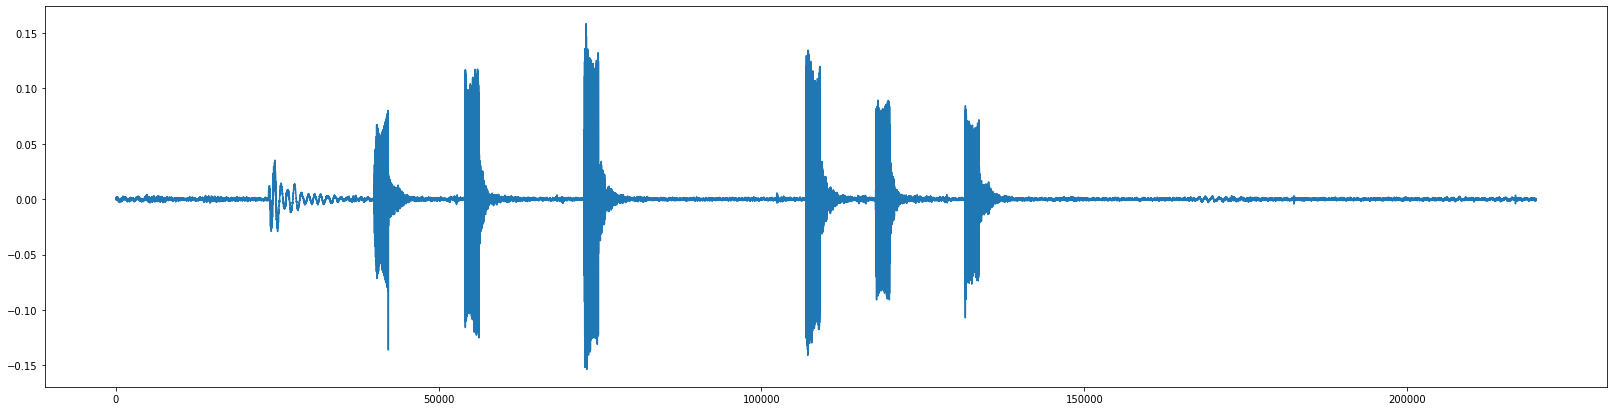

In [10]:
# Sinal inicial do áudio gravado

pp.figure(figsize=(28,7))
pp.plot(sound_wave)
pp.show()

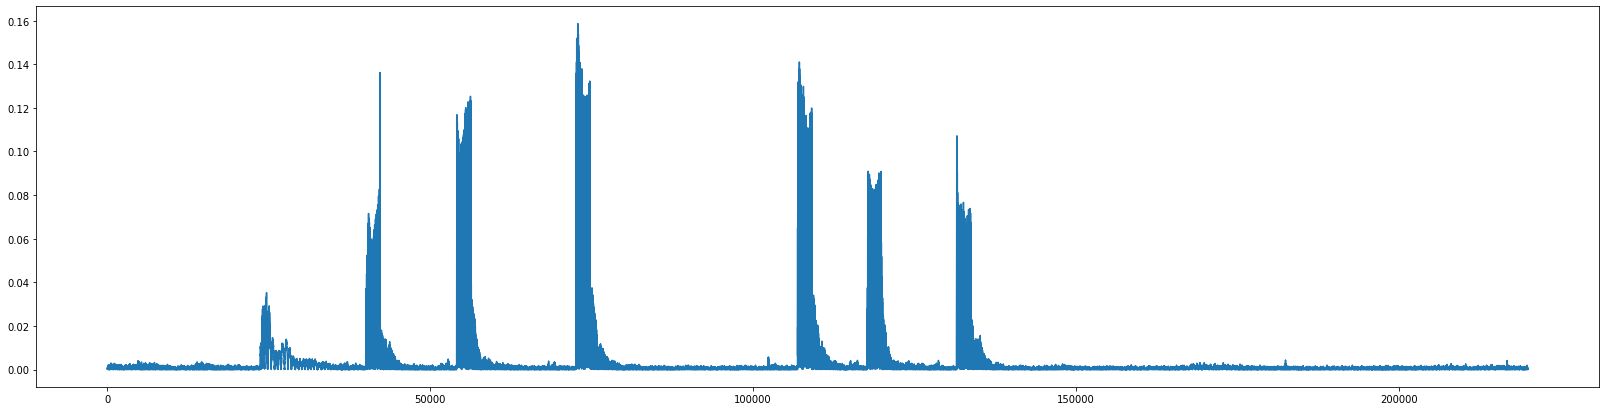

In [11]:
# Sinal em módulo do áudio gravado

pp.figure(figsize=(28,7))
pp.plot(np.absolute(sound_wave))
pp.show()

### Agora, ao invés de utilizarmos os valores gravados, utilizamos a média móvel dos valores, resultando em um sinal mais limpo e polido.

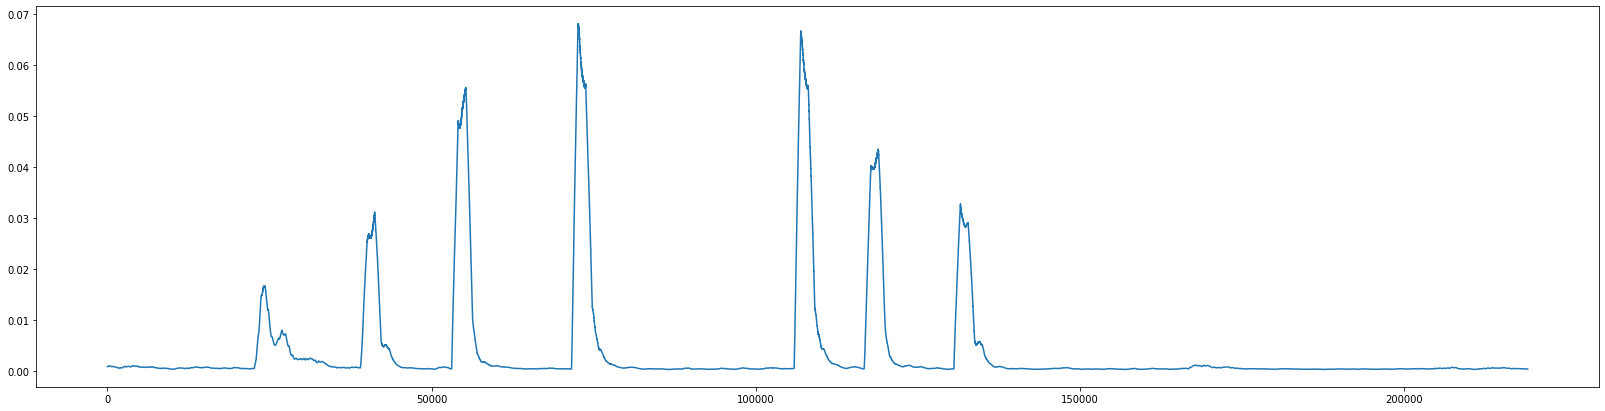

In [14]:
# Calcula as médias móveis
def moving_average(arr, n=1000) :
    ret = np.cumsum(arr, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

filtered_sound_wave = moving_average(np.absolute(sound_wave))

pp.figure(figsize=(28,7))
pp.plot(filtered_sound_wave)
pp.show()

### Agora, é definido o limiar de ruído, para saber o que é considerado "silêncio" e não é relevante. Trechos com a intensidade do sinal abaixo desse limiar não são considerados como parte de um som.

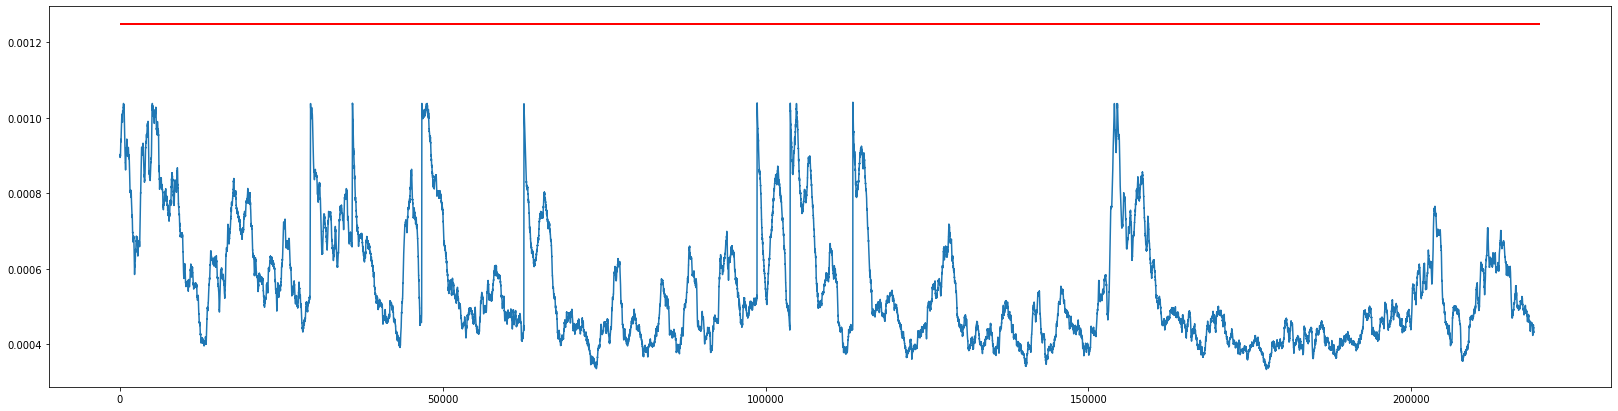

In [16]:
# Remove os outliers do conjunto de dados
def reject_outliers(data, m = 3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]
    
silence_wave = reject_outliers(filtered_sound_wave)
silence_wave = zoom(silence_wave,len(filtered_sound_wave)/len(silence_wave))

silence_max_threshold = np.max(silence_wave) * 1.2;

pp.figure(figsize=(28,7))
pp.plot(silence_wave)
pp.hlines(silence_max_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()

### Resultado após a aplicação dos filtros, com o sinal original, o sinal filtrado e o limiar de ruído.

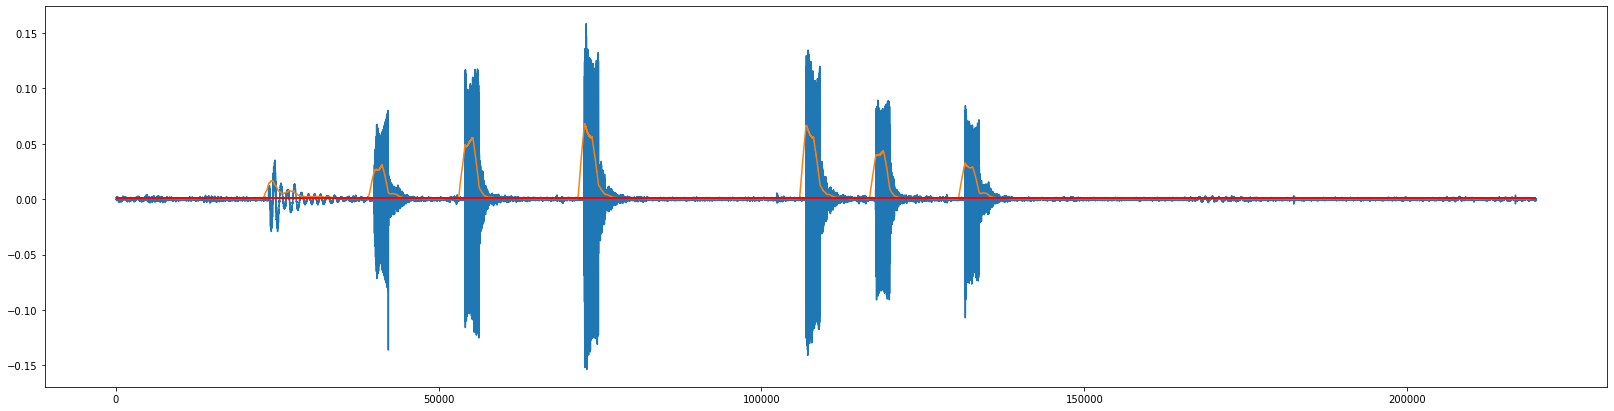

In [17]:
# visualização do audio gravado

pp.figure(figsize=(28,7))
pp.plot(sound_wave)
pp.plot(filtered_sound_wave)
pp.hlines(silence_max_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()


### Agora, entram os mínimos quadrados:

O audio gravado pode ser descrito como:

$$
S(t) = \sum_{n=1}^{8} A_n \times \sin{ (\phi_n 2\pi t + \sigma_n)}
$$

Sendo $A$ a amplitude de cada frequência $n$, e $\sigma_n$ a fase de cada um dos sinais. Utilizando o seno da soma, podemos desenvolver essa expressão para:


$$
S(t) = \sum_{n=1}^{8} A_n [\sin{(\phi_n 2\pi t)}\cos{(\sigma_n)} + \sin{(\sigma_n)}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} [\underbrace{A_n \cos(\sigma_n)}_{x_{2n-1}}\sin{(\phi_n 2\pi t)}
 + \overbrace{A_n \sin{(\sigma_n)}}^{x_{2n}}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} x_{2n-1}\sin{(\phi_n 2\pi t)} + \sum_{n=1}^{8} x_{2n}\cos{(\phi_n2\pi t)}, \; A_n = \sqrt{x_{2n}^2 + x_{2n-1}^2}
$$

Assim, podemos ver que teremos 16 equações com diferentes coeficientes para serem encontrados. Podemos fazer isso aplicando o **método dos mínimos quadrados**. 

Aqueles que tiverem as maiores amplitudes serão os relacionados ao digito que buscamos

In [20]:
#simplificação, ao invés de criarmos 16 funções diferentes podemos criar apenas essa
def mmq(time, n):
    frequency = int(n/2)
    val = DTMF_FREQUENCIES[frequency] * math.pi * 2 * time
    return math.sin(val) if (n % 2 == 0) else math.cos(val)


A = np.zeros(shape=(SOUND_WAVE_ROWS, 16))
for i in range(0, SOUND_WAVE_ROWS):
    for j in range(0, 16):
        A[i][j] = mmq(i * DELTA_T, j)


Utilizando as equações normais temos que $\hat{x}$ é uma solução para $ Ax = B <=> A^{T}A \hat{x} = A^{T}b$ 

In [21]:

A_T = A.T

A_T_dot_A = A_T @ A
A_T_dot_b = A_T @ sound_wave

print(A_T_dot_A.shape, A.shape)
print(A_T_dot_b.shape, sound_wave.shape)

result = np.linalg.solve(A_T_dot_A, A_T_dot_b)
print(result.shape, result)

(16, 16) (220000, 16)
(16, 1) (220000, 1)
(16, 1) [[-2.56967268e-04]
 [-4.70994547e-05]
 [-1.84867457e-04]
 [-2.39477949e-04]
 [-4.88998147e-05]
 [ 1.69086476e-05]
 [-5.41095099e-06]
 [ 4.73308628e-06]
 [ 1.06897225e-04]
 [ 9.46727351e-05]
 [-1.33654991e-03]
 [ 3.28026629e-04]
 [ 1.47595571e-03]
 [-3.16219985e-04]
 [-7.19909384e-07]
 [ 8.55040708e-07]]


In [22]:


def get_max_frequency_idxs(frequency_matrix):
    range_array = np.zeros((8))
    j = 0
    for i in range(0, 16, 2):
        curr_frequency = (frequency_matrix[i]**2 + frequency_matrix[i+1]**2)**(1/2)
        range_array[j] = curr_frequency
        j += 1
    return range_array[0:4].argmax(axis=0), range_array[4:8].argmax(axis=0), range_array


low_freq_idx, high_freq_idx , range_array= get_max_frequency_idxs(result)
print(range_array)
print(f"{DTMF_LOW_FREQUENCIES[low_freq_idx]}Hz & {DTMF_HIGH_FREQUENCIES[high_freq_idx]}Hz : {DTMF_DICT[low_freq_idx][high_freq_idx]}");



[2.61248034e-04 3.02532089e-04 5.17406440e-05 7.18891482e-06
 1.42793359e-04 1.37621479e-03 1.50945035e-03 1.11774958e-06]
770Hz & 1477Hz : 6
